In [1]:
import FileHandler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
from AudioMIDIAligner.PureAligner import *

all_songs = FileHandler.get_all_songs()

In [4]:
plt.rcParams.update({'font.size': 14})
# Take a 25-song sample from the MIDI files
with open('/media/daphne/Seagate Expansion Drive/Data/Results/Tables/MidiLabsResultsBar.csv', 'r') as read_file:
    content = read_file.readlines()
audio_keys = []
midi_names = []
alignment_qualities = []
for line in content:
    parts = line.split(';')
    audio_keys.append(int(parts[0]))
    midi_names.append(parts[2])
    alignment_qualities.append(float(parts[3]))

In [41]:
from random import sample
indices = sample(range(len(midi_names)), 25)
audio_keys = [audio_keys[i] for i in indices]
midi_names = [midi_names[i] for i in indices]
alignment_qualities = [alignment_qualities[i] for i in indices]
midi_names

['056-003',
 '031-007',
 '086-002',
 '024-004',
 '180-006',
 '177-003',
 '091-003',
 '080-003',
 '084-002',
 '015-003',
 '073-001',
 '035-002',
 '107-003',
 '131-003',
 '186-002',
 '143-002',
 '080-002',
 '071-001',
 '168-002',
 '124-002',
 '049-003',
 '017-007',
 '061-003',
 '097-003',
 '029-007']

In [6]:
from AudioMIDIAligner.AlignmentExporter import *

# for i in range(25):
#     full_audio_path = '/media/daphne/Seagate Expansion Drive/Data/Input/Audio/' + str(audio_keys[i]) + '.wav'
#     original_midi_path = '/media/daphne/Seagate Expansion Drive/Data/Input/MIDI/' + midi_names[i] + '.mid'
#     alignment_path = FileHandler.get_full_alignment_path(midi_names[i])
#     alignment = Alignment.from_alignment_file(alignment_path)
#     export_alignment_to_wav(alignment, '/media/daphne/Seagate Expansion Drive/Data/' + midi_names[i] + '.wav')

In [7]:
original_midi_path = '/media/daphne/Seagate Expansion Drive/Data/Input/MIDI/005-002.mid'
alignment_path = FileHandler.get_full_alignment_path('005-002')
alignment = Alignment.from_alignment_file(alignment_path)
export_alignment_to_wav(alignment, '/media/daphne/Seagate Expansion Drive/Data/005-002.wav')

In [8]:
for i in range(25):
    print midi_names[i] + ' & ' + str(alignment_qualities[i]) + ' &  \\\\'

001-001 & 0.972638885738 &  \\
001-002 & 0.682234361794 &  \\
001-003 & 0.715648155227 &  \\
001-004 & 0.678531803578 &  \\
002-001 & 0.64376222416 &  \\
002-002 & 0.717412420453 &  \\
003-001 & 0.771038935039 &  \\
003-002 & 0.705395276468 &  \\
003-003 & 0.705674609024 &  \\
003-004 & 0.763766802065 &  \\
004-001 & 0.872315352199 &  \\
004-002 & 0.697279550012 &  \\
005-001 & 0.664745926475 &  \\
005-003 & 0.664761168148 &  \\
005-004 & 0.71981762704 &  \\
006-001 & 0.636275810533 &  \\
006-002 & 0.677541426159 &  \\
006-003 & 0.782630584158 &  \\
007-002 & 0.59328112227 &  \\
007-003 & 0.699188491249 &  \\
007-004 & 0.697296534094 &  \\
007-005 & 0.755361435846 &  \\
007-006 & 0.980521864347 &  \\
007-007 & 0.712498808181 &  \\
007-001 & 0.617482739802 &  \\


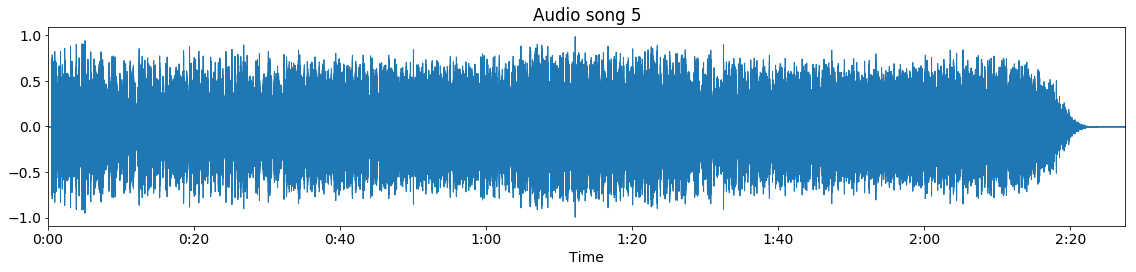

In [9]:
full_audio_path = '/media/daphne/Seagate Expansion Drive/Data/Input/Audio/5.wav'

# Open the audio file
audio_data, _ = librosa.load(full_audio_path, sr=FS)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(audio_data, sr=FS)
plt.title('Audio song '  + FileHandler.get_file_name_from_full_path(full_audio_path))
plt.tight_layout()

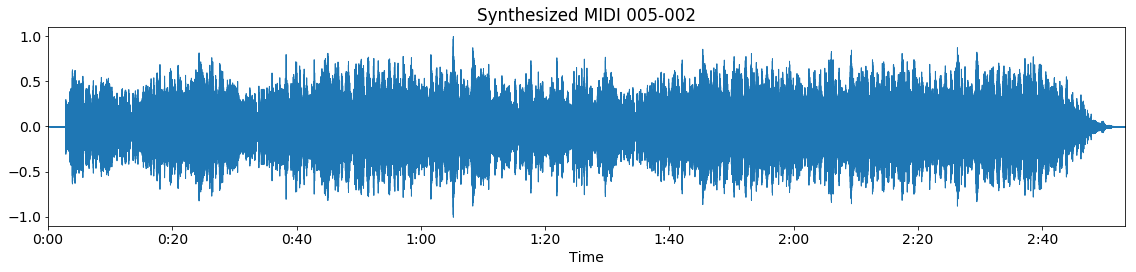

In [10]:
full_synthesized_midi_path = '/media/daphne/Seagate Expansion Drive/Data/Files/SynthMIDI/005-002.wav'

# Open the synthesized midi file
midi_audio, _ = librosa.load(full_synthesized_midi_path, sr=FS)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(midi_audio, sr=FS)
plt.title('Synthesized MIDI ' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path))
plt.tight_layout()

/home/daphne/PycharmProjects/chordrecognizer/venv/local/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


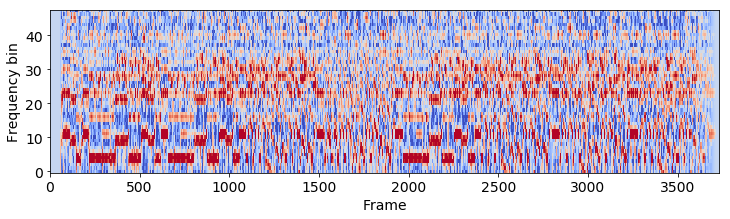

In [11]:
def display_cqt(cqt):
    """ Plot a CQT with sane defaults """
    plt.imshow(cqt.T, aspect='auto', interpolation='nearest',
               origin='lower', cmap=plt.cm.coolwarm,
               vmin=np.percentile(cqt, 5), vmax=np.percentile(cqt, 95))
    plt.xlabel('Frame')
    plt.ylabel('Frequency bin')

midi_cqt, midi_times = compute_cqt(midi_audio)
plt.figure(figsize=(12, 3))
display_cqt(midi_cqt)

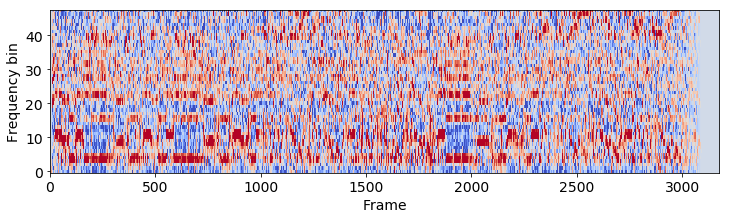

In [12]:
audio_cqt, audio_times = compute_cqt(audio_data)
plt.figure(figsize=(12, 3))
display_cqt(audio_cqt)

In [13]:
import scipy.spatial

# Compute the distance matrix of the midi and audio CQTs, using cosine distance
distance_matrix = scipy.spatial.distance.cdist(midi_cqt, audio_cqt, 'cosine')
penalty = float(np.median(np.ravel(distance_matrix)))
# Get lowest cost path in the distance matrix
p, q, score = dtw(distance_matrix, GULLY, penalty)
# Normalize by path length and the distance matrix sub-matrix within the path
score = score / len(p)
score = score / distance_matrix[p.min():p.max(), q.min():q.max()].mean()

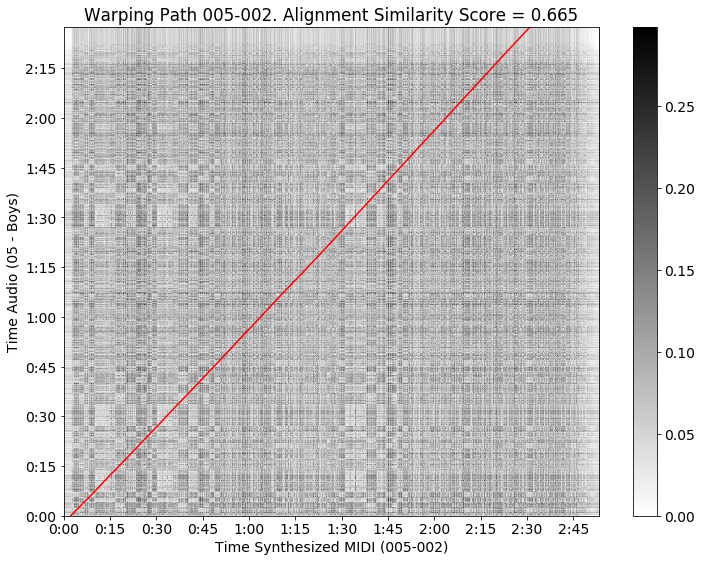

In [31]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
librosa.display.specshow(distance_matrix.T, x_axis='time', y_axis='time',
                         cmap=plt.get_cmap('gray_r'), hop_length=HOP_LENGTH)
imax = ax.imshow(distance_matrix, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(midi_times[p], audio_times[q], color='r')
plt.title('Warping Path ' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + '. Alignment Similarity Score = ' + str(round(score, 3)))

plt.xticks(np.arange(0, 170, step=15))
plt.ylabel('Time Audio (' + all_songs[int(FileHandler.get_file_name_from_full_path(full_audio_path))].title + ')')
plt.xlabel('Time Synthesized MIDI (' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + ')')
plt.colorbar()

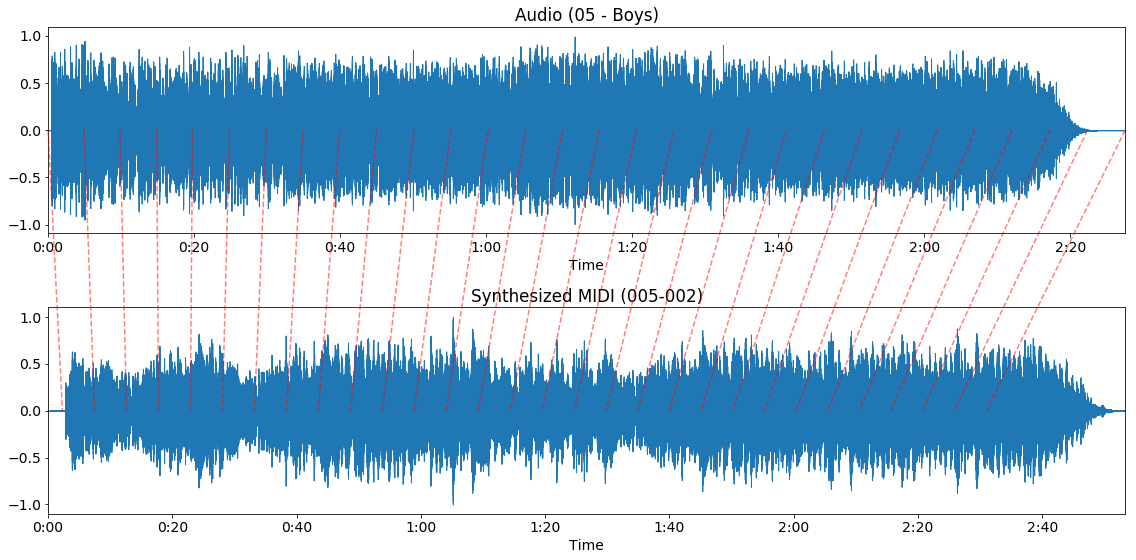

In [16]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(audio_data, sr=FS)
plt.title('Audio (' + all_songs[int(FileHandler.get_file_name_from_full_path(full_audio_path))].title + ')')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(midi_audio, sr=FS)
plt.title('Synthesized MIDI (' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + ')')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, len(p) - 1, arrows)))

for i in points_idx:
    tp2 = midi_times[p[i]]
    tp1 = audio_times[q[i]]
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r', alpha=0.5, linestyle='dashed')
    lines.append(line)

fig.lines = lines
plt.tight_layout()

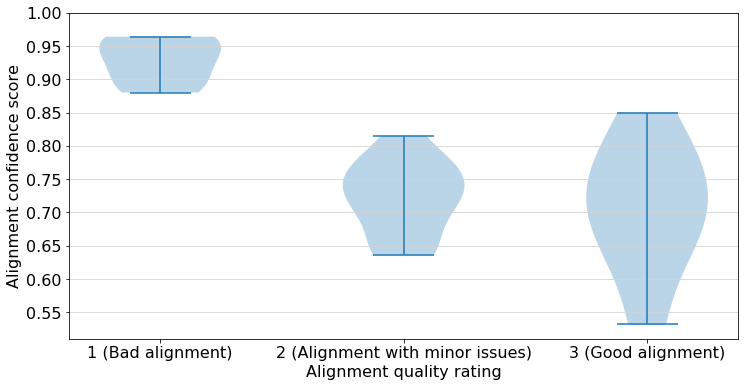

In [2]:
i = [[0.723, 2], [0.762, 2], [0.636, 2], [0.934, 1], [0.764, 3], [0.850, 3], [0.656, 3], 
[0.959, 1], [0.723, 2], [0.903, 1], [0.720, 3], [0.654, 2], [0.815, 2], [0.705, 2], 
[0.964, 1], [0.644, 2], [0.762, 2], [0.880, 1], [0.760, 2], [0.712, 3], [0.771, 2], 
[0.709, 2], [0.784, 3], [0.641, 3], [0.532, 3]]
enen = [x[0] for x in i if x[1] == 1]
tweeen = [x[0] for x in i if x[1] == 2]
drieen = [x[0] for x in i if x[1] == 3]

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
ax.violinplot([enen, tweeen, drieen], [1,2,3])
ax.set_xticks([1,2,3])
ax.set_xticklabels(['1 (Bad alignment)', '2 (Alignment with minor issues)', '3 (Good alignment)'])
ax.set_yticks([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
ax.grid(True, linestyle='-', which='major', axis='y', color='lightgrey', alpha=1)
ax.set_xlabel('Alignment quality rating')
ax.set_ylabel('Alignment confidence score')
plt.savefig('/media/daphne/Seagate Expansion Drive/Data/Results/Figures/Alignment/ViolinPlot', bbox_inches="tight", pad_inches=0)